In [28]:
# %matplotlib inline
# Authors: MJ Bayazi <mj.darvishi92@gmail.com>
#
# License: BSD (3-clause)

In [29]:
# install all the required packages
!pip install braindecode gdown asrpy


# Download, Load, Preprocess and Save the TUH and NMT EEG Corpus

In this project, we investigate scaling law for transfer learning in normal/abnormal classification on the TUH and NMT EEG Corpus.


In [30]:
# Loading Libraries
from collections import Counter
import numpy as np
import mne
mne.set_log_level('ERROR')  # avoid messages everytime a window is extracted

from braindecode.preprocessing import (
    preprocess, Preprocessor,# create_fixed_length_windows, scale as multiply
    )
from numpy import multiply

from braindecode.datasets.tuh import TUHAbnormal, TUH
from nmt import NMT
import gdown

In [31]:
Exp_Path = 'YOUR_PATH'  # specify the path to the experiment folder
TUAB_raw_path = Exp_Path + '/tuab/tuab_raw'
NMT_raw_path = Exp_Path + '/NMT/nmt_raw'
TUAB_pp_path = Exp_Path + '/tuab/tuab_pp'
NMT_pp_path = Exp_Path + '/NMT/nmt_pp'
RESULTS_path = Exp_Path + '/results/'
N_JOBS = 1  # specify the number of jobs for loading and windowing

# make all the necessary directories
import os
os.makedirs(TUAB_raw_path, exist_ok=True)
os.makedirs(NMT_raw_path, exist_ok=True)
os.makedirs(TUAB_pp_path, exist_ok=True)
os.makedirs(NMT_pp_path, exist_ok=True)
os.makedirs(RESULTS_path, exist_ok=True)

## Creating the dataset using _TUHAbnormalMock and _NMTnormalMock

Since the data is not available easily, we are required to mock some of the dataset functionality. Therefore, if you
want to try this code with the actual data, please disconsider this section. and download the data from the original sources as expained in the next section.

In [32]:
from braindecode.datasets.tuh import _TUHAbnormalMock as TUHAbnormal
from nmt import _NMTMock as NMT

## or Download the original datasets
We can download the datasets, uncomment the below cell

In [33]:
# # download datasets
# ## TUH
# !rsync -auxvL nedc-eeg@www.isip.piconepress.com:data/eeg/tuh_eeg_abnormal/ TUAB_raw_path #you need the password see https://isip.piconepress.com/projects/tuh_eeg/html/downloads.shtml
# ## NMT
# url = 'https://drive.google.com/file/d/1jGRm5fzj9pp0pGn_FS7P6kbUhzyiK6O-/view?usp=sharing'
# gdown.download(url, NMT_raw_path + '/nmt_scalp_eeg_dataset.zip', quiet=False,fuzzy=True)
# !unzip NMT_raw_path + 'nmt_scalp_eeg_dataset.zip

We start by loading TUH and NMT datasets.

Selecting dataset

In [34]:
dataset = 'nmt' # specify the dataset to be used 'tuab' OR 'nmt'. You need to do this before running the next cell for both datasets

if dataset == 'tuab':
    tuh_ds = TUHAbnormal(
    TUAB_raw_path, 
    target_name=('pathological', 'age', 'gender'),
    # recording_ids=range(100),#or None to load the whole dataset,
    preload=False,
    n_jobs=1 if TUHAbnormal.__name__ == '_TUHAbnormalMock' else N_JOBS
            )
    print(tuh_ds.description)
    selected_ds = tuh_ds
    PATH_pp = TUAB_pp_path 
elif dataset == 'nmt':
    nmt_ds = NMT(
    NMT_raw_path, 
    target_name=('pathological', 'age', 'gender'),
    # recording_ids=range(100,200),#or None to load the whole dataset,
    preload=False,
    # n_jobs=N_JOBS
    )
    nmt_ds.description
    selected_ds = nmt_ds
    PATH_pp = NMT_pp_path

Iterating through the dataset gives x as ndarray(n_channels x 1) as well as
the target as [age of the subject, gender of the subject]. Let's look at the last example
as it has more interesting age/gender labels (compare to the last row of the dataframe above).



In [35]:
x, y = selected_ds[-1]
print('x:', x.shape)
print('y:', y)

x: (21, 1)
y: [False, 71, 'M']


In [36]:
raw = selected_ds.datasets[0].raw


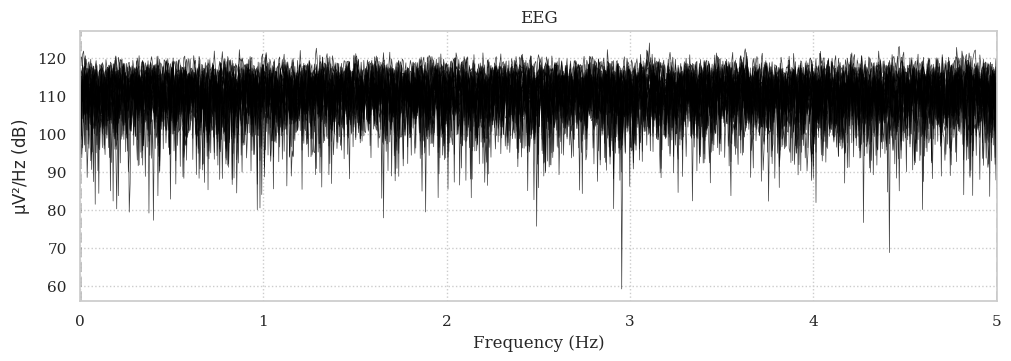

In [37]:
raw.plot_psd()

Next, we will perform some preprocessing steps. First, we will do some
selection of available recordings based on the duration. We will select those
recordings, that have at least five minutes duration. Data is not loaded here.
Then we will do some basic preprocessings for both datasets. 

In [38]:

def keep_unique (ds):
    # keep only unique subjects
    df = ds.description

    subjects = df['subject']
    unique_subjects = df['subject'].unique()
    print(f'There are {len(subjects)} subjects in the dataset')
    print(f'There are {len(unique_subjects)} unique subjects in the dataset')

    # Create a new column 'status' that marks duplicates as 'duplicate' and unique values as 'unique'
    df['status'] = df.duplicated('subject')
    df['status'] = df['status'].replace({True: 'duplicate', False: 'unique'})

    ds.set_description(df, overwrite=True)

    # Keep only one record per subject
    ds = ds.split('status')['unique']
    return ds

def remove_common (ds):
    # Remove noisy labbled subjects
    df = ds.description
    # Split the dataframe by pathological column
    groups = df.groupby('gender')

    # Access each group as a dataframe
    df_yes = groups.get_group('F')
    df_no = groups.get_group('M')

    # Display the first five rows of each group
    df_yes.head()
    df_no.head()

    # Get the unique subjects in each group
    subjects_yes = set(df_yes['subject'].unique())
    subjects_no = set(df_no['subject'].unique())

    # Find the intersection of the two sets
    common_subjects = subjects_yes.intersection(subjects_no)

    # Display the common subjects
    print(f'there are {len(common_subjects)} common subjects in the two pathological groups')

    # Filter the dataframe by the common subjects
    df_common = df[df['subject'].isin(common_subjects)]

    # Display the number of rows of the filtered dataframe
    print(f'There are {len(df_common)} out of {len(df)} rows have their status changed')

    # Create a new column named 'common' with boolean values
    df = df.assign(common=df['subject'].isin(common_subjects))

    # Display the first five rows of the dataframe
    # df.head()
    ds.set_description(df, overwrite=True)

    ds = ds.split('common')['False']
    
    return ds
## end of remove noisy labbled subjects

In [39]:
def select_by_duration(ds, tmin=0, tmax=None):
    if tmax is None:
        tmax = np.inf
    # determine length of the recordings and select based on tmin and tmax
    split_ids = []
    for d_i, d in enumerate(ds.datasets):
        duration = d.raw.n_times / d.raw.info['sfreq']
        if tmin <= duration <= tmax:
            split_ids.append(d_i)
    splits = ds.split(split_ids)
    split = splits['0']
    return split

In [40]:
tmin = 5 * 60
tmax = None

remove_common_flag = False

if remove_common_flag:
    print(len(selected_ds.description))
    selected_ds = select_by_duration(selected_ds, tmin, tmax)
    print(len(selected_ds.description))
    selected_ds = keep_unique(selected_ds)
    print(len(selected_ds.description))
    selected_ds = remove_common(selected_ds)
    print(len(selected_ds.description))

In [41]:
# TUH spesific channel PP
short_ch_names = sorted([
    'A1', 'A2',
    'FP1', 'FP2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
    'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']) 
ar_ch_names = sorted([
    'EEG A1-REF', 'EEG A2-REF',
    'EEG FP1-REF', 'EEG FP2-REF', 'EEG F3-REF', 'EEG F4-REF', 'EEG C3-REF',
    'EEG C4-REF', 'EEG P3-REF', 'EEG P4-REF', 'EEG O1-REF', 'EEG O2-REF',
    'EEG F7-REF', 'EEG F8-REF', 'EEG T3-REF', 'EEG T4-REF', 'EEG T5-REF',
    'EEG T6-REF', 'EEG FZ-REF', 'EEG CZ-REF', 'EEG PZ-REF'])
le_ch_names = sorted([
    'EEG A1-LE', 'EEG A2-LE',
    'EEG FP1-LE', 'EEG FP2-LE', 'EEG F3-LE', 'EEG F4-LE', 'EEG C3-LE',
    'EEG C4-LE', 'EEG P3-LE', 'EEG P4-LE', 'EEG O1-LE', 'EEG O2-LE',
    'EEG F7-LE', 'EEG F8-LE', 'EEG T3-LE', 'EEG T4-LE', 'EEG T5-LE',
    'EEG T6-LE', 'EEG FZ-LE', 'EEG CZ-LE', 'EEG PZ-LE'])
assert len(short_ch_names) == len(ar_ch_names) == len(le_ch_names)
ar_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    ar_ch_names, short_ch_names)}
le_ch_mapping = {ch_name: short_ch_name for ch_name, short_ch_name in zip(
    le_ch_names, short_ch_names)}
ch_mapping = {'ar': ar_ch_mapping, 'le': le_ch_mapping}


def select_by_channels(ds, ch_mapping):
    split_ids = []
    for i, d in enumerate(ds.datasets):
        ref = 'ar' if d.raw.ch_names[0].endswith('-REF') else 'le'
        # these are the channels we are looking for
        seta = set(ch_mapping[ref].keys())
        # these are the channels of the recoding
        setb = set(d.raw.ch_names)
        # if recording contains all channels we are looking for, include it
        if seta.issubset(setb):
            split_ids.append(i)
    return ds.split(split_ids)['0']

if 'tu' in dataset:
    selected_ds = select_by_channels(selected_ds, ch_mapping)

selected_ds.description

,path,pathological,age,gender,n_samples,sfreq,train
0,nmt_scalp_eeg_dataset/abnormal/train/0000036.edf,False,35,M,3600,10.0,True
1,nmt_scalp_eeg_dataset/abnormal/eval/0000037.edf,True,28,F,3600,10.0,False
2,nmt_scalp_eeg_dataset/abnormal/eval/0000038.edf,False,62,M,3600,10.0,False
3,nmt_scalp_eeg_dataset/normal/train/0000039.edf,True,41,F,3600,10.0,True
4,nmt_scalp_eeg_dataset/normal/eval/0000040.edf,False,19,M,3600,10.0,False
5,nmt_scalp_eeg_dataset/normal/eval/0000041.edf,True,55,F,3600,10.0,False
6,nmt_scalp_eeg_dataset/abnormal/train/0000042.edf,False,71,M,3600,10.0,True


In [ ]:
import asrpy

def custom_crop(raw, tmin=0.0, tmax=None, include_tmax=True):
    # crop recordings to tmin – tmax. can be incomplete if recording
    # has lower duration than tmax
    # by default mne fails if tmax is bigger than duration
    tmax = min((raw.n_times - 1) / raw.info['sfreq'], tmax)
    raw.crop(tmin=tmin, tmax=tmax, include_tmax=include_tmax)

def custom_rename_channels(raw, mapping):
    # rename channels which are dependent on referencing:
    # le: EEG 01-LE, ar: EEG 01-REF
    # mne fails if the mapping contains channels as keys that are not present
    # in the raw
    if 'EEG' in raw.ch_names[0]: #just for tuh
        reference = raw.ch_names[0].split('-')[-1].lower()
        assert reference in ['le', 'ref'], 'unexpected referencing'
        reference = 'le' if reference == 'le' else 'ar'
        raw.rename_channels(mapping[reference])
def custom_reset_date(raw):
    # resolve this error: info["meas_date"] seconds must be between "(-2147483648, 0)" and "(2147483647, 0)"
    print(raw.info["meas_date"])
    raw.anonymize()

def apply_asr(raw):
    try:
        # filter the data between 1 and 75 Hz
        raw.load_data()
        raw.filter(l_freq=1., h_freq=None, fir_design='firwin',
            skip_by_annotation='edge')
        #run asr 
        asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=5)
        asr.fit(raw.copy())
        raw = asr.transform(raw.copy())
    except:
        print('Could not apply the ASR')
 
# one recording assumed to be equal to one subject (TUAB has multiple sessions per subject)
def normalize_one_recording_channel_wise(clean_eeg_data):
    
    # raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=True)
    ch_names = short_ch_names #raw.ch_names

    # do your data cleaning/preprocessing pipeline here
    # clean_epochs or clean_raw = ...

    # for sake of illustration
    # clean_eeg_data = raw.get_data()
    print(clean_eeg_data.shape)

    # compute stats only on clean segments
    means = []
    stds = []
    for i in range(len(ch_names)):
        means.append(np.mean(clean_eeg_data[i, :]))
        stds.append(np.std(clean_eeg_data[i, :]))
    
    ## apply clip to 2 stds
    #and
    # apply z-score normalization to clean_data
    normalized_clean_eeg_data = []
    for i in range(len(ch_names)):
        #   clip to 2 stds
        clean_eeg_data[i, :] = np.clip(clean_eeg_data[i, :],a_min=means[i]-2*stds[i],a_max=means[i]+2*stds[i])
        #   z-score normalization
        # clean_eeg_data[i, :] = (clean_eeg_data[i, :] - means[i]) / stds[i] # zscoring
        clean_eeg_data[i, :] = (clean_eeg_data[i, :] - np.mean(clean_eeg_data[i, :])) / np.std(clean_eeg_data[i, :]) # zscoring

        ## scaling to be in [0 1] range
        # clean_eeg_data[i, :] = (clean_eeg_data[i, :] - min(clean_eeg_data[i, :])) / (max(clean_eeg_data[i, :]) - min(clean_eeg_data[i, :]))
    #     normalized_clean_eeg_data.append(normalized_channel)
    # normalized_clean_eeg_data = np.array(normalized_clean_eeg_data); print(normalized_clean_eeg_data.shape)

    return clean_eeg_data #normalized_clean_eeg_data

tmin = 1 * 60
tmax = 6 * 60
sfreq = 100

preprocessors = [
    Preprocessor(custom_crop, tmin=tmin, tmax=tmax, include_tmax=False,
                 apply_on_array=False),
            
    # Preprocessor('set_eeg_reference', ref_channels='average', ch_type='eeg'),
    Preprocessor(custom_rename_channels, mapping=ch_mapping,
                 apply_on_array=False),
    Preprocessor('pick_channels', ch_names=short_ch_names, ordered=True),
    # Preprocessor(multiply, factor=1*1e6 if dataset=='nmt' else 1e6, apply_on_array=True),
    Preprocessor(lambda data: multiply(data, 1*1e6), apply_on_array=True),  # Convert from V to uV
    Preprocessor(custom_reset_date,apply_on_array=False),
    Preprocessor(np.clip, a_min=-800, a_max=800, apply_on_array=True),
    Preprocessor('resample', sfreq=sfreq),
    # Preprocessor(apply_asr,apply_on_array=False),
    Preprocessor('set_eeg_reference', ref_channels='average', ch_type='eeg'),
    # Preprocessor(normalize_one_recording_channel_wise, apply_on_array=True),

]

In [43]:
## creating ds_pp folder
import os
import shutil

def create_pp_folder(dir_name):
    # Check if directory already exists
    if os.path.exists(dir_name):
        # Remove directory if it already exists
        shutil.rmtree(dir_name)

    # Create new directory
    os.mkdir(dir_name)

create_pp_folder(PATH_pp)

In [ ]:
selected_preproc = preprocess(
    concat_ds=selected_ds,
    preprocessors=preprocessors,
    n_jobs=N_JOBS,
    save_dir=PATH_pp,
    overwrite=False,
)

Our datasets are preprocessed and saved to the given directories. Now we cann move to the training notebook.

Visuliziation

In [45]:
selected_ds.datasets[-1].raw.info['ch_names']

['A1',
 'A2',
 'C3',
 'C4',
 'CZ',
 'F3',
 'F4',
 'F7',
 'F8',
 'FP1',
 'FP2',
 'FZ',
 'O1',
 'O2',
 'P3',
 'P4',
 'PZ',
 'T3',
 'T4',
 'T5',
 'T6']

In [46]:
print(f'dataset: {dataset} preprocessing was successful')

dataset: nmt preprocessing was successful


In [47]:
raw = selected_preproc.datasets[0].raw

In [48]:
selected_preproc.datasets[0].description

path            nmt_scalp_eeg_dataset/abnormal/train/0000036.edf
pathological                                               False
age                                                           35
gender                                                         M
n_samples                                                   3600
sfreq                                                       10.0
train                                                       True
dtype: object

In [49]:
(raw.get_data().max())

2227.79296875

In [50]:
(raw.get_data().min())

-2914.954345703125

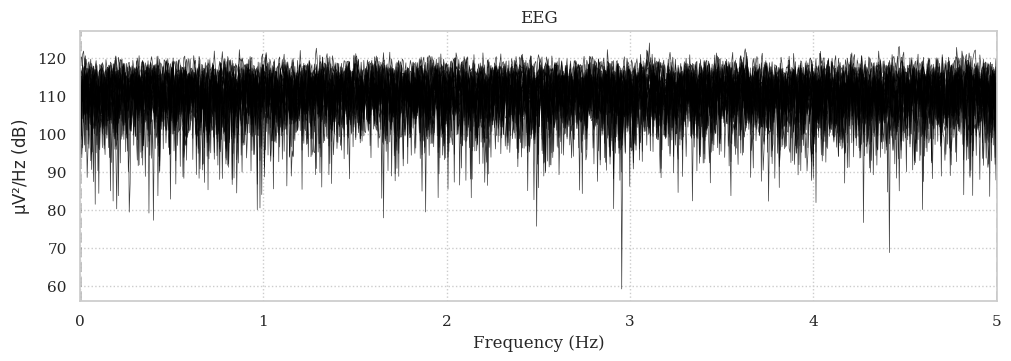

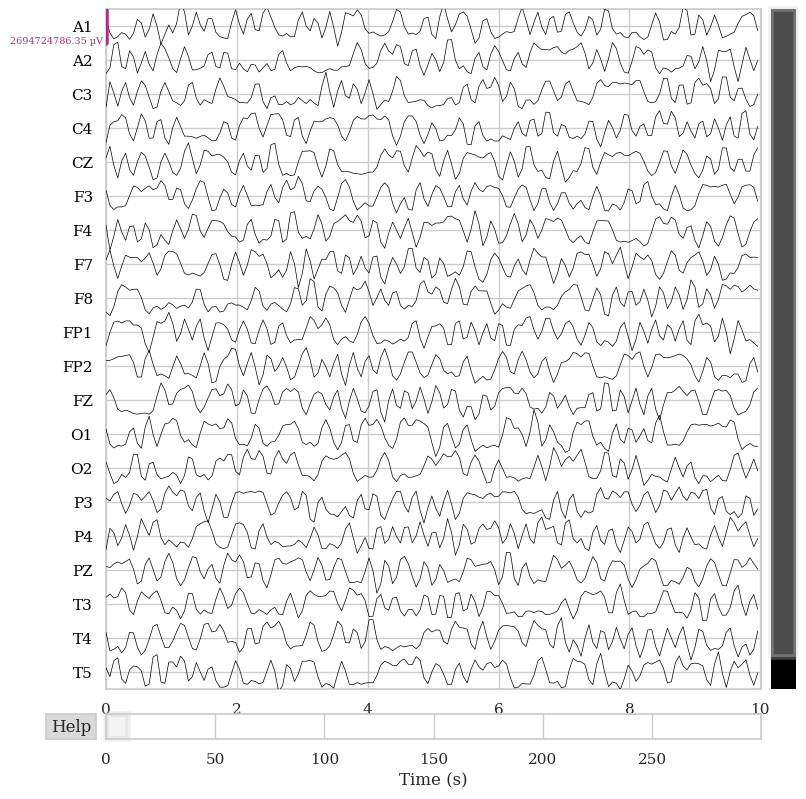

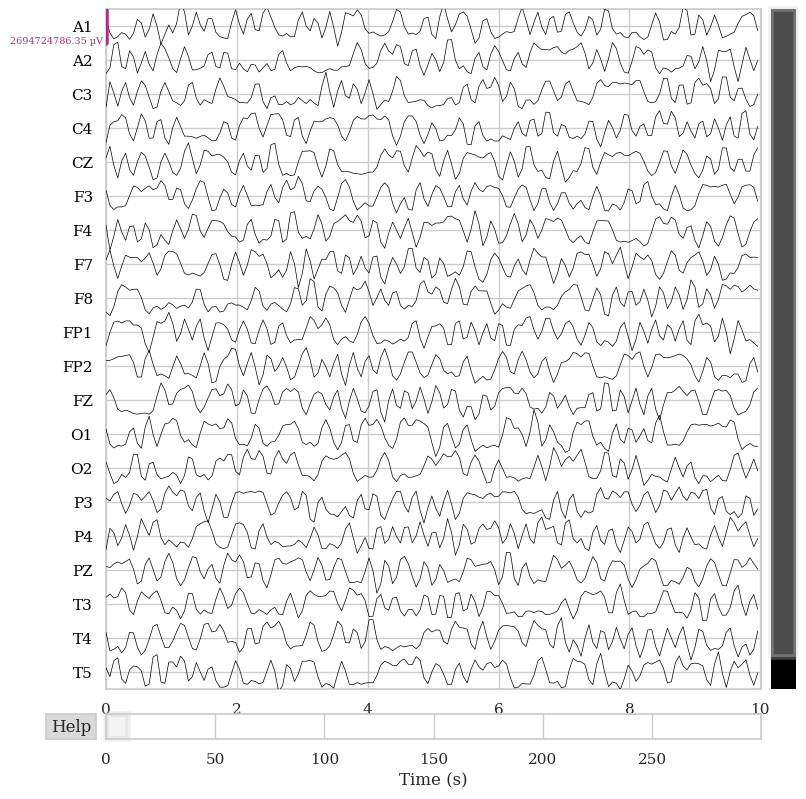

In [51]:
raw.plot(scalings='auto')

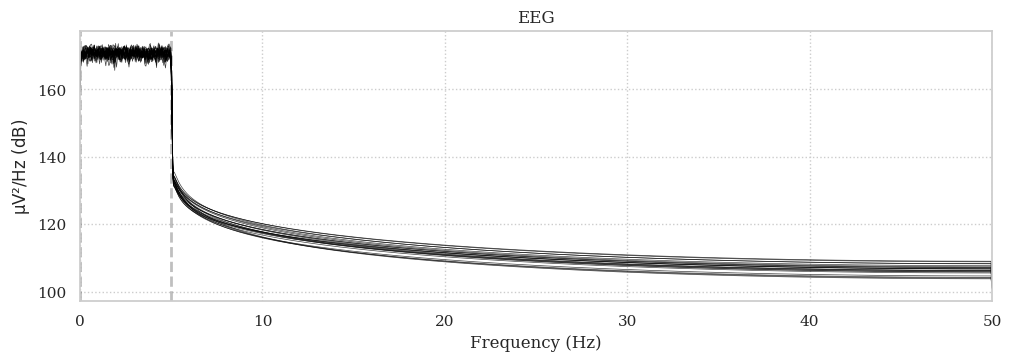

In [52]:
raw.plot_psd(fmax=50)

2227.79296875
-2914.954345703125


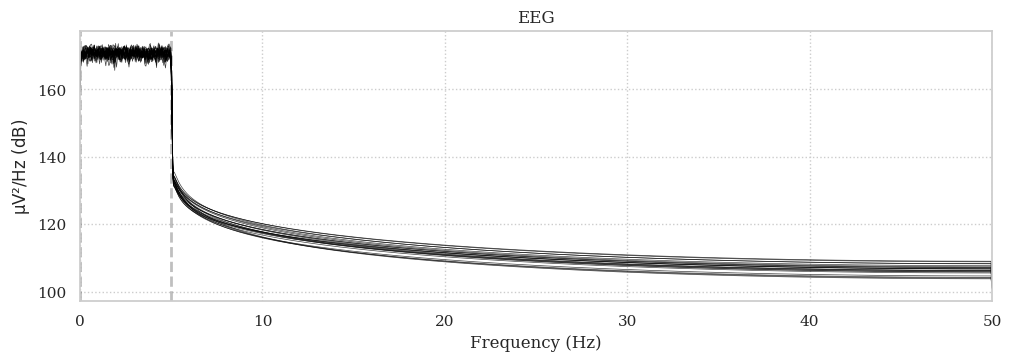

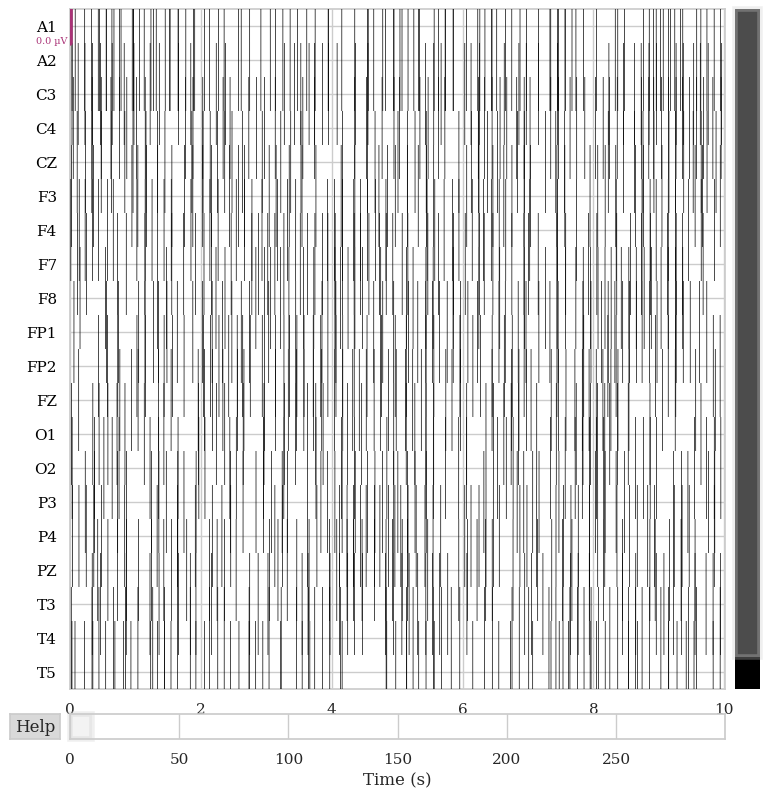

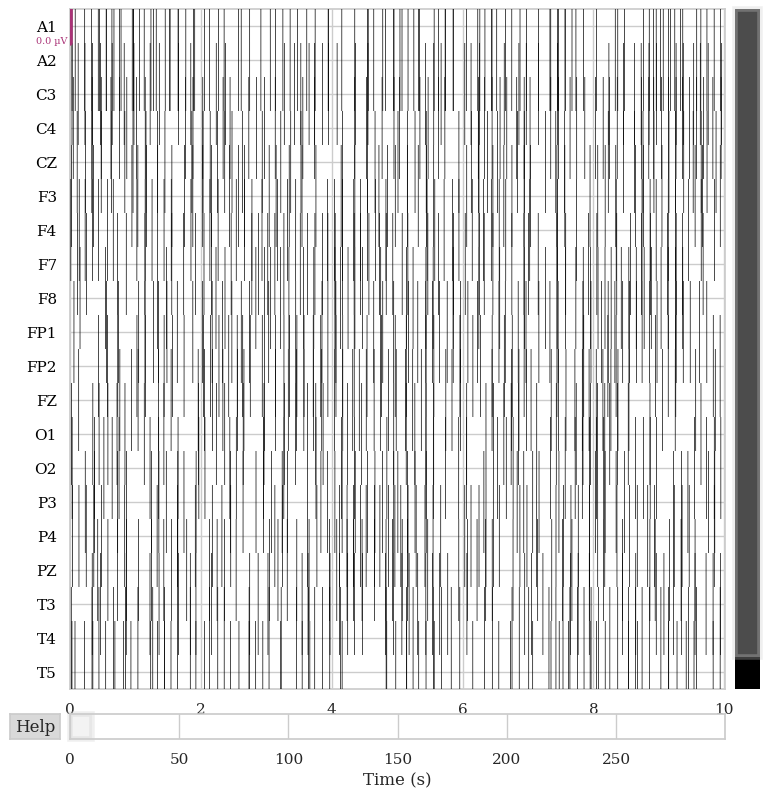

In [53]:
raw2 = selected_preproc.datasets[0].raw
print(raw2.get_data().max())
print(raw2.get_data().min())
raw2.plot(scalings=False)

2227.79296875
-2914.954345703125


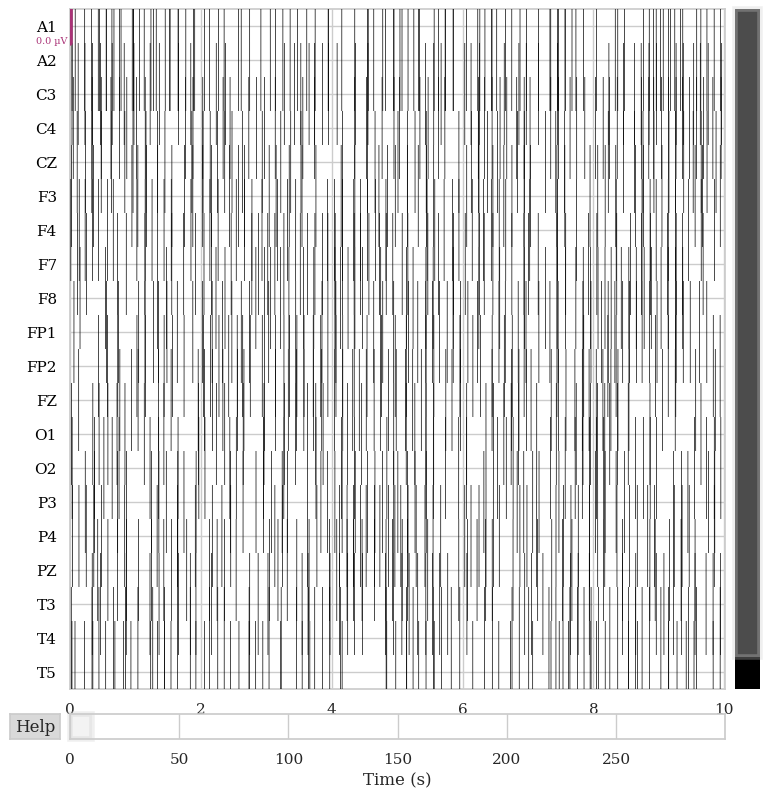

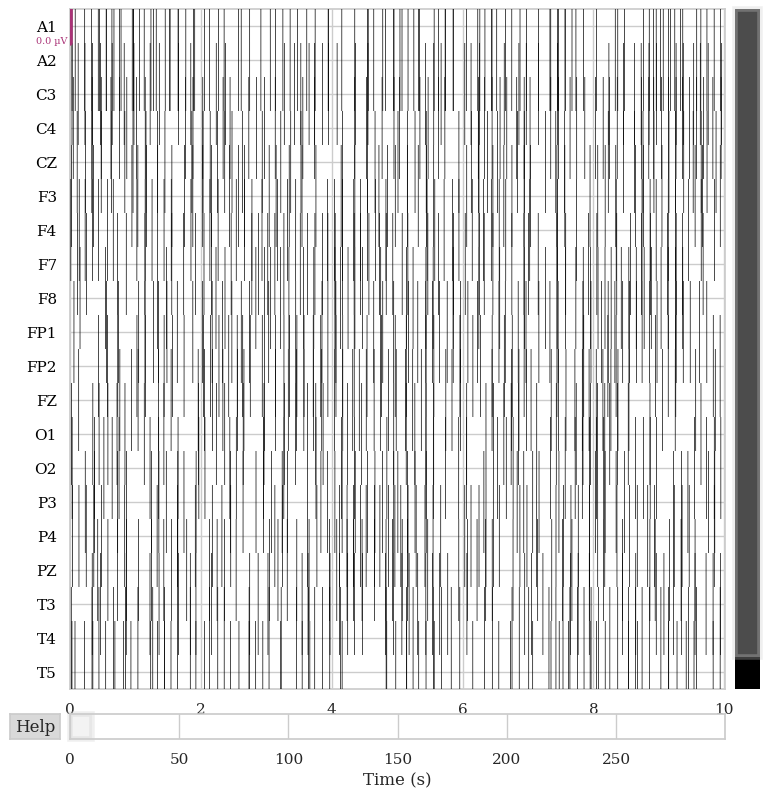

In [54]:
raw3 = selected_preproc.datasets[0].raw
print(raw3.get_data().max())
print(raw3.get_data().min())
raw3.plot(scalings=False)